In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import os, sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import unicodedata
import collections
from datetime import datetime
import random
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [2]:
nba_stats = pd.read_csv('players_stats_ben.csv')
newdata =  pd.read_csv('additionaldata.csv',encoding='Windows-1252')

# Convert all player name to string
nba_stats['Player'] = nba_stats['Player'].astype(str)
newdata['Player'] = newdata['Player'].astype(str)

# Change player names in latin to ascii
nba_stats['Player'] = nba_stats['Player'].apply(lambda val: unicodedata.normalize('NFKD', val).encode('ascii', 'ignore').decode())
newdata['Player'] = newdata['Player'].apply(lambda val: unicodedata.normalize('NFKD', val).encode('ascii', 'ignore').decode())

# Remove * from player names
nba_stats = nba_stats.replace('\*','',regex=True)
newdata = newdata.replace('\*','',regex=True)

# Append the new data to original dataframe
nba_df = nba_stats.append(newdata)

nba_df = nba_df.iloc[nba_df.Tm.ne('TOT').argsort(kind='mergesort')].drop_duplicates(['Year', "Player"])

nba_team_data = pd.read_csv('team_data_ben.csv')

teamlists = nba_team_data["awayAbbr"].unique()
seasons = nba_team_data["season"].unique()


teamscheduleaway = {}
for team in teamlists:
            teamscheduleaway["{0}".format(team)] = np.array(nba_team_data[nba_team_data['awayAbbr'] == team].index)
        
teamscheduleahome = {}
for team in teamlists:
            teamscheduleahome["{0}".format(team)] = np.array(nba_team_data[nba_team_data['homeAbbr'] == team].index)

nba_df_2000 = nba_df[(nba_df['Year'] >= 2001) & (nba_df['Year'] != 2020)]
nba_team_data = nba_team_data[nba_team_data['season'] != '2019-20']

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     49.62
Date:                Fri, 14 May 2021   Prob (F-statistic):           3.81e-54
Time:                        15:38:35   Log-Likelihood:                -1973.4
No. Observations:                 536   AIC:                             3963.
Df Residuals:                     528   BIC:                             3997.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.8581      3.297      4.507      0.0

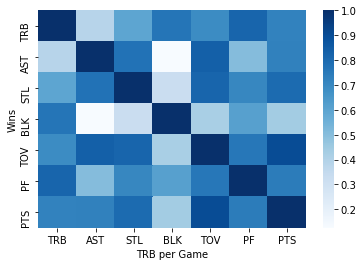

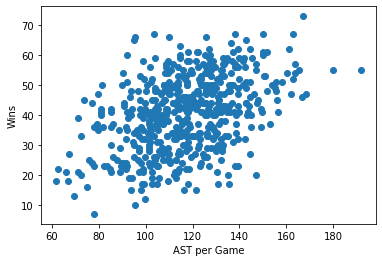

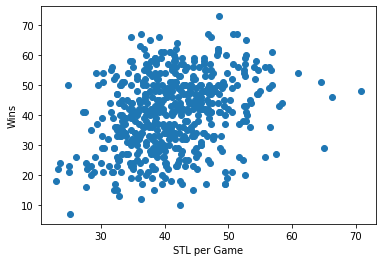

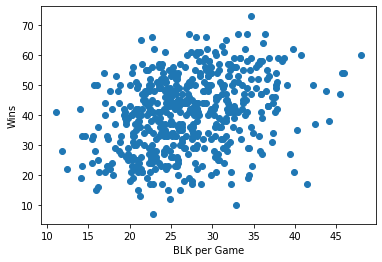

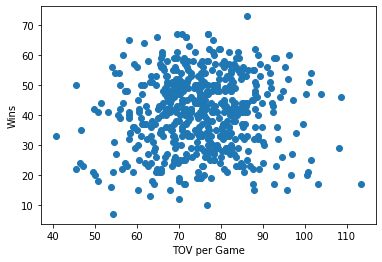

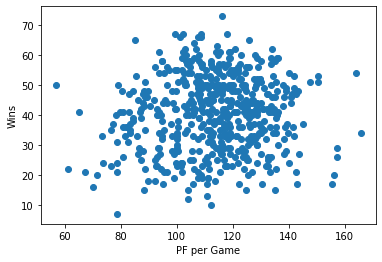

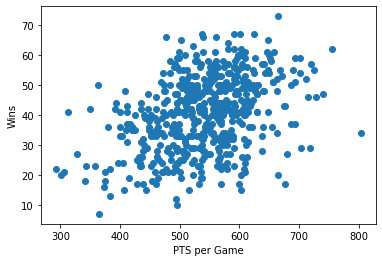

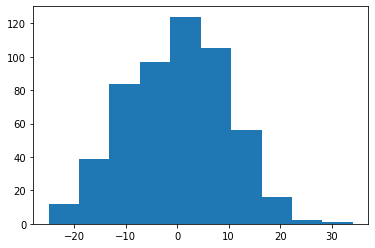

In [3]:
# OLS for 2000-2018, predict 2019
wins_train = np.array(nba_team_data[nba_team_data['season'] != '2018-19'].groupby(by=['matchWinner', 'season']).count()['gmDate'])
wins_test = np.array(nba_team_data[nba_team_data['season'] == '2018-19'].groupby(by=['matchWinner', 'season']).count()['gmDate'])
nba_df_2000_train = nba_df_2000[nba_df_2000['Year'] != 2019].groupby(by=['Tm', 'Year']).mean()
nba_df_2000_train = nba_df_2000_train.drop(index='TOT')
nba_df_2000_train = nba_df_2000_train[['TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']]
nba_df_2000_train = sm.add_constant(nba_df_2000_train)
nba_df_2000_test = nba_df_2000[nba_df_2000['Year'] == 2019].groupby(by=['Tm', 'Year']).mean()
nba_df_2000_test = nba_df_2000_test.drop(index='TOT')
nba_df_2000_test = nba_df_2000_test[['TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']]
nba_df_2000_test = sm.add_constant(nba_df_2000_test)

# look at correlation between variables for multicollinearity
sns.heatmap(nba_df_2000[['TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']].corr(), cmap='Blues')

# look at scatter plots of each variable
for i in nba_df_2000_train.columns[1:]:
    plt.scatter(nba_df_2000_train[i].to_numpy(dtype=float), wins_train.astype(float))
    plt.ylabel('Wins')
    plt.xlabel(i + ' per Game')
    plt.figure()

# show model results
model = sm.OLS(wins_train, nba_df_2000_train)
results = model.fit()
print(results.summary(), '\n')

# plot the residuals    
plt.hist(results.resid)

# calculate t values based on EHW SEs
labels = ['OLS', 'HC0', 'HC1', 'HC2', 'HC3']
hc_df = pd.DataFrame((1/(results.bse), 1/(results.HC0_se), 1/(results.HC1_se), 1/(results.HC2_se), 1/(results.HC3_se)), 
                     index=labels)
hc_table = round((hc_df * results.params).T, ndigits=2)
print(hc_table, '\n')

# verify OLS results using QR decomposition
Q, R = np.linalg.qr(nba_df_2000_train)
print(np.linalg.inv(R) @ Q.T @ wins_train, '\n')

# predict 2019 results and calculate the RMSE based on true values
print(results.predict(nba_df_2000_test), '\n')
print(np.sqrt(((results.predict(nba_df_2000_test) - wins_test) ** 2).mean()))


In [4]:
# Bring in data
nba_df = pd.read_csv('nba_stats.csv')




In [5]:
# Convert all player name to string
nba_df['Player'] = nba_df['Player'].astype(str)

# Change player names in latin to ascii
nba_df['Player'] = nba_df['Player'].apply(lambda val: unicodedata.normalize('NFKD', val).encode('ascii', 'ignore').decode())




In [6]:
# Remove data where players are traded mid-season based on TOT
nba_df.drop(nba_df[nba_df['Tm'] == "TOT"].index, inplace = True)
display(nba_df)

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight
1,2000,Tariq Abdul-Wahad,SG,25,ORL,46,46,1205,14.4,0.484,...,162,239,72,53,16,87,116,563,198,101
2,2000,Tariq Abdul-Wahad,SG,25,DEN,15,10,373,10.8,0.448,...,28,52,26,6,12,19,31,134,198,101
3,2000,Shareef Abdur-Rahim,SF,23,VAN,82,82,3223,20.2,0.547,...,607,825,271,89,87,249,244,1663,206,102
4,2000,Cory Alexander,PG,26,DEN,29,2,329,8.8,0.381,...,34,42,58,24,2,28,39,82,185,83
5,2000,Ray Allen,SG,24,MIL,82,82,3070,20.6,0.570,...,276,359,308,110,19,183,187,1809,203,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11570,2019,Tyler Zeller,C,29,ATL,2,0,11,1.5,0.000,...,4,6,1,0,0,0,4,0,213,114
11571,2019,Tyler Zeller,C,29,MEM,4,1,82,19.4,0.640,...,9,18,3,1,3,4,16,46,213,114
11572,2019,Ante Zizic,C,22,CLE,59,25,1082,16.2,0.590,...,212,320,53,13,22,61,113,459,210,113
11574,2019,Ivica Zubac,C,21,LAL,33,12,516,19.5,0.633,...,108,162,25,4,27,33,73,281,216,120


In [7]:
# Convert total stats to per game stats 
nba_df = nba_df.dropna(subset=['ORB', '2P%', 'TOV'])
nan_names = list(set(nba_df.columns.tolist()) - set(['Year']))
nba_df[nan_names] = nba_df[nan_names].fillna(0)

nba_df["2P/G"] = nba_df['2P']/nba_df["G"]
nba_df["2PA/G"] = nba_df['2PA']/nba_df["G"]
nba_df["3P/G"] = nba_df['3P']/nba_df["G"]
nba_df["3PA/G"] = nba_df['3PA']/nba_df["G"]
nba_df["FT/G"] = nba_df['FT']/nba_df["G"]
nba_df["FTA/G"] = nba_df['FTA']/nba_df["G"]
nba_df["ORB/G"] = nba_df['ORB']/nba_df["G"]
nba_df["DRB/G"] = nba_df['DRB']/nba_df["G"]
nba_df["AST/G"] = nba_df['AST']/nba_df["G"]
nba_df["STL/G"] = nba_df['STL']/nba_df["G"]
nba_df["BLK/G"] = nba_df['BLK']/nba_df["G"]
nba_df["TOV/G"] = nba_df['TOV']/nba_df["G"]
nba_df["PF/G"] = nba_df['PF']/nba_df["G"]
nba_df["MP/G"] = nba_df['MP']/nba_df["G"]
nba_df["PTS/G"] = nba_df['PTS']/nba_df["G"]
nba_df['Year']=nba_df['Year'].astype('float')


In [8]:
nba_df_rookies = nba_df.groupby('Player').first().reset_index()
nba_df_rookies = nba_df_rookies[nba_df_rookies["Year"]<2019]
nba_df_rookies = nba_df_rookies.dropna()
display(nba_df_rookies)


,Player,Year,Pos,Age,Tm,G,GS,MP,PER,TS%,...,FTA/G,ORB/G,DRB/G,AST/G,STL/G,BLK/G,TOV/G,PF/G,MP/G,PTS/G
0,A.C. Green,2000.0,PF,36,LAL,82,82,1929,11.2,0.482,...,1.158537,1.951220,3.975610,0.975610,0.646341,0.219512,0.646341,1.548780,23.524390,5.036585
1,A.J. Bramlett,2000.0,C,23,CLE,8,0,61,-0.4,0.190,...,0.000000,1.500000,1.250000,0.000000,0.125000,0.000000,0.375000,1.625000,7.625000,1.000000
2,A.J. Guyton,2001.0,PG,22,CHI,33,8,630,10.3,0.495,...,0.545455,0.303030,0.787879,1.939394,0.272727,0.151515,0.727273,1.060606,19.090909,6.000000
3,A.J. Hammons,2017.0,C,24,DAL,22,0,163,8.4,0.472,...,0.909091,0.363636,1.272727,0.181818,0.045455,0.590909,0.454545,0.954545,7.409091,2.181818
4,A.J. Price,2010.0,PG,23,IND,56,2,865,14.0,0.530,...,1.339286,0.214286,1.357143,1.892857,0.625000,0.053571,1.053571,0.946429,15.446429,7.321429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909,Zendon Hamilton,2001.0,C,25,LAC,3,0,19,5.7,0.359,...,2.666667,1.000000,1.666667,0.000000,0.000000,0.000000,0.666667,1.333333,6.333333,3.000000
1911,Zhou Qi,2018.0,C,22,HOU,18,0,124,1.9,0.295,...,0.666667,0.333333,0.888889,0.111111,0.111111,0.777778,0.555556,0.777778,6.888889,1.222222
1912,Zoran Dragic,2015.0,SG,25,PHO,6,0,13,9.1,0.322,...,0.500000,0.333333,0.166667,0.166667,0.000000,0.000000,0.000000,0.166667,2.166667,1.000000
1913,Zoran Planinic,2004.0,SG,21,NJN,49,1,473,10.0,0.492,...,1.224490,0.285714,0.836735,1.387755,0.265306,0.061224,0.734694,1.428571,9.653061,3.122449


In [9]:
'''
nba_df = pd.read_csv('Player_Stats/Seasons_Stats.csv')
nba_df = nba_df.dropna(subset=['ORB'])
nba_df = nba_df.loc[nba_df['PTS'] != 0.0]
display(nba_df)
print(nba_df.isnull().sum())
Also view explanations by holding mouse over column headers
Season -- If listed as single number, the year the season ended.
★ - Indicates All-Star for league.
Only on regular season tables.
Age -- Player's age on February 1 of the season
Year -- Indicates end of the season time
Tm -- Team
Lg -- League
Pos -- Position
G -- Games
GS -- Games Started
MP -- Minutes Played Per Game
FG -- Field Goals Per Game
FGA -- Field Goal Attempts Per Game
FG% -- Field Goal Percentage
3P -- 3-Point Field Goals Per Game
3PA -- 3-Point Field Goal Attempts Per Game
3P% -- 3-Point Field Goal Percentage
2P -- 2-Point Field Goals Per Game
2PA -- 2-Point Field Goal Attempts Per Game
2P% -- 2-Point Field Goal Percentage
eFG% -- Effective Field Goal Percentage
This statistic adjusts for the fact that a 3-point field goal is worth one more point than a 2-point field goal.
FT -- Free Throws Per Game
FTA -- Free Throw Attempts Per Game
FT% -- Free Throw Percentage
ORB -- Offensive Rebounds Per Game
DRB -- Defensive Rebounds Per Game
TRB -- Total Rebounds Per Game
AST -- Assists Per Game
STL -- Steals Per Game
BLK -- Blocks Per Game
TOV -- Turnovers Per Game
PF -- Personal Fouls Per Game
PTS -- Points Per Game
'''
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))


# Variables to standardize '2P/G','2PA/G','3P/G','3PA/G','FT/G','FTA/G','ORB/G','DRB/G','AST/G','STL/G','BLK/G','TOV/G','PF/G','MP/G','Age','height','weight'

standardizedcolumns = ['Age','height','weight']

new_columns = []
for i in standardizedcolumns:
    new_columns.append(i + "_s")
nba_df_rookies[new_columns] = standardize(nba_df_rookies[standardizedcolumns])

In [10]:
player_draft_cluster = pd.read_csv('player_draft_cluster.csv')
player_draft_cluster = player_draft_cluster.drop(['birthyear','age'], axis = 1)
player_draft_cluster = player_draft_cluster.dropna()
player_draft_cluster['draft_group'] = player_draft_cluster['draft'].apply(lambda x: 1 if x < 11 else 2 if x < 21 else 3 if x<31 else 4 if x<41 else 5 if x<51 else 6)


In [11]:
nba_df_rookies.drop_duplicates(subset=['Player'])
nba_df_rookies_stats = nba_df.merge(player_draft_cluster, on='Player', how='left')
nba_df_rookies_stats['draft_group'] = nba_df_rookies_stats['draft_group'].replace(np.nan, 6)
nba_df_rookies_stats['draft_group'] = nba_df_rookies_stats['draft_group'].astype("str")
nba_df_rookies_stats=nba_df_rookies_stats.drop_duplicates(subset=['Player'])
nba_df_rookies_stats

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,AST/G,STL/G,BLK/G,TOV/G,PF/G,MP/G,PTS/G,draft,firstseason,draft_group
0,2000.0,Tariq Abdul-Wahad,SG,25,ORL,46,46,1205,14.4,0.484,...,1.565217,1.152174,0.347826,1.891304,2.521739,26.195652,12.239130,11.0,1998.0,2.0
2,2000.0,Shareef Abdur-Rahim,SF,23,VAN,82,82,3223,20.2,0.547,...,3.304878,1.085366,1.060976,3.036585,2.975610,39.304878,20.280488,3.0,1997.0,1.0
3,2000.0,Cory Alexander,PG,26,DEN,29,2,329,8.8,0.381,...,2.000000,0.827586,0.068966,0.965517,1.344828,11.344828,2.827586,29.0,1996.0,3.0
4,2000.0,Ray Allen,SG,24,MIL,82,82,3070,20.6,0.570,...,3.756098,1.341463,0.231707,2.231707,2.280488,37.439024,22.060976,5.0,1997.0,1.0
5,2000.0,Rafer Alston,PG,23,MIL,27,0,361,4.3,0.310,...,2.592593,0.444444,0.000000,1.074074,1.074074,13.370370,2.222222,39.0,2000.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10496,2019.0,Thomas Welsh,C,22,DEN,11,0,36,16.1,0.648,...,0.454545,0.000000,0.000000,0.090909,0.272727,3.272727,1.636364,58.0,2019.0,6.0
10504,2019.0,Johnathan Williams,C,23,LAL,24,0,372,15.1,0.599,...,0.541667,0.333333,0.291667,0.666667,2.583333,15.500000,6.541667,61.0,2019.0,6.0
10505,2019.0,Kenrich Williams,SF,24,NOP,46,29,1079,9.7,0.485,...,1.804348,0.978261,0.413043,0.782609,2.065217,23.456522,6.065217,61.0,2019.0,6.0
10508,2019.0,Robert Williams,C,21,BOS,32,2,283,18.8,0.703,...,0.218750,0.281250,1.250000,0.312500,1.125000,8.843750,2.531250,NaN,NaN,6.0


In [12]:
def offensiveload(assist, box_creation, fga, fta, turnovers):
    OL = (assist-(0.38*box_creation)*0.75)+fga+fta*0.44+box_creation+turnovers
    return OL

def box_creation(assist,points,turnovers,threept_proficiency):
    box = (assist*0.1843)+(points+turnovers)*0.0969-2.3021*(threept_proficiency)+0.0582*(assist*(points+turnovers)*threept_proficiency)-1.1942
    return box

def threept_proficiency(threepa, threepercent):
    threepro=(2/(1+np.exp(-threepa))-1)*threepercent
    return threepro

In [13]:
nba_df_rookies_stats["FGA/G"] = nba_df_rookies_stats["FGA"]/ nba_df_rookies_stats["G"]
nba_df_rookies_stats["three_pro"] = threept_proficiency(nba_df_rookies_stats["3PA/G"],
                                                                  nba_df_rookies_stats["3P%"])
nba_df_rookies_stats["bc"] = box_creation(nba_df_rookies_stats["AST/G"],
                                                    nba_df_rookies_stats["PTS/G"],
                                                    nba_df_rookies_stats["TOV/G"],
                                                    nba_df_rookies_stats["three_pro"])

nba_df_rookies_stats["ol"] = offensiveload(nba_df_rookies_stats["AST/G"],
                                                    nba_df_rookies_stats["bc"],
                                                    nba_df_rookies_stats["FGA/G"],
                                                    nba_df_rookies_stats["FTA/G"],
                                                    nba_df_rookies_stats["TOV/G"])


Variance Explained [0.85010039 0.0834935 ]


<ipython-input-14-9fc6d6c1e761>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_df_rookies_filtered['label'] = label


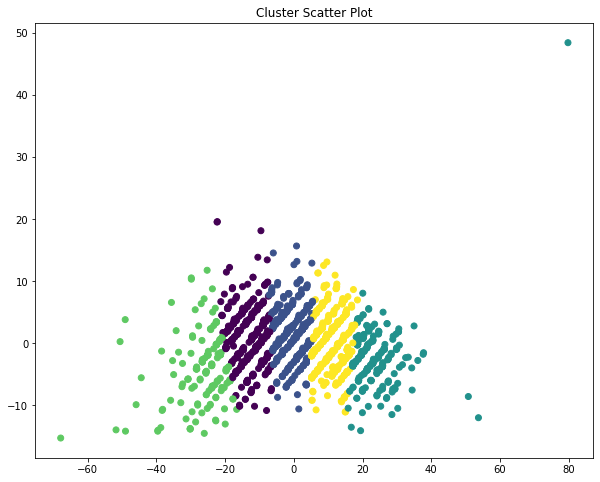

In [14]:
nba_df_rookies_filtered = nba_df_rookies_stats[['Age','height','weight','draft_group']]

pca = PCA(n_components = 2, random_state=420)
pca.fit(nba_df_rookies_filtered)
scores_pca = pca.transform(nba_df_rookies_filtered)


kmeans = KMeans(n_clusters=5, random_state = 420)
label = kmeans.fit_predict(scores_pca)
nba_df_rookies_filtered['label'] = label

def plot_clusters(X, clusters):
    plt.scatter(X[:, 0], X[:, 1], c=clusters)

plt.figure(figsize=(10,8))
plot_clusters(scores_pca, nba_df_rookies_filtered['label'])
plt.title("Cluster Scatter Plot")

print("Variance Explained",pca.explained_variance_ratio_)


In [15]:
nba_df_rookies_stats['label'] = label

nba_df_rookies_stats2 = nba_df_rookies_stats[nba_df_rookies_stats["Year"]<2019]


In [16]:
mod = smf.ols(formula='ol ~ three_pro + bc * C(label)-1',data=nba_df_rookies_stats2).fit()
print(mod.summary())



                            OLS Regression Results                            
Dep. Variable:                     ol   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     3159.
Date:                Fri, 14 May 2021   Prob (F-statistic):               0.00
Time:                        15:38:36   Log-Likelihood:                -3303.7
No. Observations:                1808   AIC:                             6629.
Df Residuals:                    1797   BIC:                             6690.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
C(label)[0]          9.5326      0.086  

                     OLS    HC0    HC1    HC2    HC3
C(label)[0]       110.79  39.93  39.81  38.49  37.07
C(label)[1]        97.88  58.50  58.32  57.48  56.45
C(label)[2]        74.14  53.47  53.31  52.08  50.63
C(label)[3]        62.36  88.68  88.41  83.36  77.87
C(label)[4]        88.07  51.60  51.45  50.82  50.04
three_pro          33.40  28.41  28.33  28.13  27.84
bc                 81.85  20.29  20.23  19.47  18.67
bc:C(label)[T.1]   -5.41  -1.58  -1.58  -1.52  -1.46
bc:C(label)[T.2]  -18.19  -5.16  -5.14  -4.93  -4.70
bc:C(label)[T.3]    8.85   5.40   5.38   5.15   4.90
bc:C(label)[T.4]  -13.21  -3.64  -3.63  -3.51  -3.38 



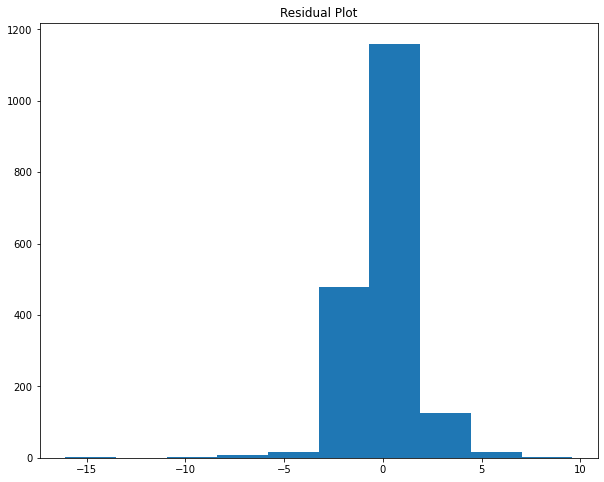

In [17]:
# plot the residuals 
plt.figure(figsize=(10,8))
plt.title("Residual Plot")
plt.hist(mod.resid)

# calculate t values based on EHW SEs
labels = ['OLS', 'HC0', 'HC1', 'HC2', 'HC3']
hc_df = pd.DataFrame((1/(mod.bse), 1/(mod.HC0_se), 1/(mod.HC1_se), 1/(mod.HC2_se), 1/(mod.HC3_se)), 
                     index=labels)
hc_table = round((hc_df * mod.params).T, ndigits=2)
print(hc_table, '\n')



In [18]:
nba_df_rookies_stats4 = nba_df_rookies_stats[nba_df_rookies_stats["Year"]==2019]
nba_df_rookies_stats4 = nba_df_rookies_stats4[["Player","label"]]

nba_df_rookies_stats4["label"] = nba_df_rookies_stats4["label"].astype("str")


three_pro_mean=nba_df_rookies_stats2.groupby('label')['three_pro'].mean().reset_index()
bc_mean=nba_df_rookies_stats2.groupby("label")['bc'].mean().reset_index()
estimatedrookiestats=pd.merge(three_pro_mean,bc_mean,on="label",how="left")
estimatedrookiestats["label"] =  estimatedrookiestats["label"].astype("str")


In [19]:
nba_df_rookies_stats4.loc[nba_df_rookies_stats4["label"] == '0', "three_pro"] = 0.059930
nba_df_rookies_stats4.loc[nba_df_rookies_stats4["label"] == '1', "three_pro"] = 0.130864
nba_df_rookies_stats4.loc[nba_df_rookies_stats4["label"] == '2', "three_pro"] = 0.162177
nba_df_rookies_stats4.loc[nba_df_rookies_stats4["label"] == '3', "three_pro"] = 0.016091
nba_df_rookies_stats4.loc[nba_df_rookies_stats4["label"] == '4', "three_pro"] = 0.159426

nba_df_rookies_stats4.loc[nba_df_rookies_stats4["label"] == '0', "bc"] = -0.516005
nba_df_rookies_stats4.loc[nba_df_rookies_stats4["label"] == '1', "bc"] = -0.538729
nba_df_rookies_stats4.loc[nba_df_rookies_stats4["label"] == '2', "bc"] = -0.206295
nba_df_rookies_stats4.loc[nba_df_rookies_stats4["label"] == '3', "bc"] = -0.568990
nba_df_rookies_stats4.loc[nba_df_rookies_stats4["label"] == '4', "bc"] = -0.349558

nba_df_rookies_stats4

,Player,label,three_pro,bc
9905,Jaylen Adams,2,0.162177,-0.206295
9908,Deng Adel,4,0.159426,-0.349558
9909,DeVaughn Akoon-Purcell,4,0.159426,-0.349558
9911,Rawle Alkins,1,0.130864,-0.538729
9912,Grayson Allen,4,0.159426,-0.349558
...,...,...,...,...
10496,Thomas Welsh,3,0.016091,-0.568990
10504,Johnathan Williams,0,0.059930,-0.516005
10505,Kenrich Williams,1,0.130864,-0.538729
10508,Robert Williams,0,0.059930,-0.516005


In [20]:
X=nba_df_rookies_stats2[["three_pro","bc","label"]]
labeldummy_train = pd.get_dummies(X['label'])
X=X.drop(["label"], axis=1)
X_train = pd.concat([X,labeldummy_train],axis=1)

X2 =nba_df_rookies_stats4[["three_pro","bc","label"]]
labeldummy_test = pd.get_dummies(X2['label'])
X2=X2.drop(["label"], axis=1)
X_test = pd.concat([X2,labeldummy_test],axis=1)
y_train = nba_df_rookies_stats2["ol"]


In [21]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

nba_df_rookies_stats4["ol"]=y_pred
nba_df_rookies_stats4

,Player,label,three_pro,bc,ol
9905,Jaylen Adams,2,0.162177,-0.206295,8.899589
9908,Deng Adel,4,0.159426,-0.349558,8.234317
9909,DeVaughn Akoon-Purcell,4,0.159426,-0.349558,8.234317
9911,Rawle Alkins,1,0.130864,-0.538729,7.096613
9912,Grayson Allen,4,0.159426,-0.349558,8.234317
...,...,...,...,...,...
10496,Thomas Welsh,3,0.016091,-0.568990,5.694208
10504,Johnathan Williams,0,0.059930,-0.516005,6.437648
10505,Kenrich Williams,1,0.130864,-0.538729,7.096613
10508,Robert Williams,0,0.059930,-0.516005,6.437648


In [22]:
nba_team_data = pd.read_csv('nba_team_data.csv')

nba_team_data['awayDist'] = nba_team_data['awayDist'].replace(np.nan, 0)
nba_team_data['homeDist'] = nba_team_data['homeDist'].replace(np.nan, 0)

nba_team_data["homecourtAbbr"] = (nba_team_data["homeAbbr"])
def Reverse(lst):
    lst.reverse()
    return lst

random.seed(42)

random_idx=random.choices(range(0, 22965),k=10000)
random_idx.sort()
nba_team_data.loc[random_idx,['awayid',
                              'awayAbbr',
                              'awayDayOff',
                              'awayDist',
                              'awayOL',
                              'homeid',
                              'homeAbbr',
                              'homeDayOff',
                              'homeDist',
                              'homeOL']] = nba_team_data.loc[random_idx,['homeid',
                                                                         'homeAbbr',
                                                                         'homeDayOff',
                                                                         'homeDist',
                                                                         'homeOL',
                                                                         'awayid',
                                                                         'awayAbbr',
                                                                         'awayDayOff',
                                                                         'awayDist',
                                                                         'awayOL']].values


nba_team_data_final = nba_team_data.rename(columns={'awayid': 'team1id',
                                                    'awayAbbr': 'team1abbr',
                                                    'awayDayOff': 'team1dayoff',
                                                    'awayDist': 'team1dist',
                                                    'awayOL': 'team1ol',
                                                    'homeid': 'team2id',
                                                    'homeAbbr': 'team2abbr',
                                                    'homeDayOff': 'team2dayoff',
                                                    'homeDist': 'team2dist',
                                                    'homeOL': 'team2ol'})
                                                 
nba_team_data_final["winner"] = np.where(nba_team_data_final["matchWinner"]==nba_team_data_final["team1abbr"],1,0)
nba_team_data_final["homecourt"] = np.where(nba_team_data_final["homecourtAbbr"]==nba_team_data_final["team1abbr"],1,0)
                                                   
display(nba_team_data_final)


,gmDate,Year,gameid,team1id,team1abbr,team1dayoff,team1dist,team1ol,team2id,team2abbr,team2dayoff,team2ol,team2dist,possessions,matchWinner,homecourtAbbr,winner,homecourt
0,10/31/2000,2001,20000003,1610612753,ORL,10,0.000000,148.846375,1610612764,WAS,10,188.037800,0.000000,205,ORL,ORL,1,1
1,10/31/2000,2001,20000011,1610612744,GSW,10,0.000000,138.822613,1610612756,PHX,10,149.197906,0.000000,214,GSW,GSW,1,1
2,10/31/2000,2001,20000010,1610612762,UTA,10,0.000000,129.663039,1610612746,LAC,10,122.398864,0.000000,205,UTA,UTA,1,1
3,10/31/2000,2001,20000009,1610612759,SAS,10,0.000000,119.598926,1610612754,IND,10,116.194793,0.000000,191,SAS,SAS,1,1
4,10/31/2000,2001,20000008,1610612745,HOU,10,0.000000,126.939020,1610612750,MIN,10,133.496295,0.000000,203,MIN,HOU,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22960,4/10/2019,2019,21801223,1610612765,DET,0,773.384642,122.498303,1610612752,NYK,0,120.927059,1144.291274,196,DET,NYK,1,0
22961,4/10/2019,2019,21801220,1610612754,IND,2,741.155575,102.019191,1610612737,ATL,2,137.066530,1077.259449,224,IND,ATL,1,0
22962,4/10/2019,2019,21801221,1610612751,BKN,2,1031.367637,145.511502,1610612748,MIA,0,117.614362,1756.235048,226,BKN,BKN,1,1
22963,4/10/2019,2019,21801227,1610612742,DAL,0,406.265992,139.895315,1610612759,SAS,2,142.685141,2022.488572,200,SAS,SAS,0,0


In [23]:
is_NaN = nba_team_data_final.isnull()

row_has_NaN = is_NaN.any(axis=1)

rows_with_NaN = nba_team_data_final[row_has_NaN]
print(rows_with_NaN)

Empty DataFrame
Columns: [gmDate, Year, gameid, team1id, team1abbr, team1dayoff, team1dist, team1ol, team2id, team2abbr, team2dayoff, team2ol, team2dist, possessions, matchWinner, homecourtAbbr, winner, homecourt]
Index: []


In [24]:
nba_df = pd.read_csv('nba_stats.csv')
# Convert total stats to per game stats 
nba_df = nba_df.dropna(subset=['ORB', '2P%', 'TOV'])
nan_names = list(set(nba_df.columns.tolist()) - set(['Year']))
nba_df[nan_names] = nba_df[nan_names].fillna(0)

nba_df["2P/G"] = nba_df['2P']/nba_df["G"]
nba_df["2PA/G"] = nba_df['2PA']/nba_df["G"]
nba_df["3P/G"] = nba_df['3P']/nba_df["G"]
nba_df["3PA/G"] = nba_df['3PA']/nba_df["G"]
nba_df["FT/G"] = nba_df['FT']/nba_df["G"]
nba_df["FTA/G"] = nba_df['FTA']/nba_df["G"]
nba_df["ORB/G"] = nba_df['ORB']/nba_df["G"]
nba_df["DRB/G"] = nba_df['DRB']/nba_df["G"]
nba_df["AST/G"] = nba_df['AST']/nba_df["G"]
nba_df["STL/G"] = nba_df['STL']/nba_df["G"]
nba_df["BLK/G"] = nba_df['BLK']/nba_df["G"]
nba_df["TOV/G"] = nba_df['TOV']/nba_df["G"]
nba_df["PF/G"] = nba_df['PF']/nba_df["G"]
nba_df["MP/G"] = nba_df['MP']/nba_df["G"]
nba_df["PTS/G"] = nba_df['PTS']/nba_df["G"]
nba_df['Year']=nba_df['Year'].astype('float')
nba_df["FGA/G"] = nba_df["FGA"]/ nba_df["G"]
nba_df["three_pro"] = threept_proficiency(nba_df["3PA/G"],
                                                    nba_df["3P%"])
nba_df["bc"] = box_creation(nba_df["AST/G"],
                                                    nba_df["PTS/G"],
                                                    nba_df["TOV/G"],
                                                    nba_df["three_pro"])

nba_df["ol"] = offensiveload(nba_df["AST/G"],
                                                    nba_df["bc"],
                                                    nba_df["FGA/G"],
                                                    nba_df["FTA/G"],
                                                    nba_df["TOV/G"])

nba_df_2018=nba_df[nba_df["Year"]==2018][["Player","ol"]]
nba_df_2019=nba_df[nba_df["Year"]==2018][["Player","Tm"]]
nba_df_2019_rookies=nba_df_rookies_stats4[["Player","ol"]]


In [25]:
nba_df_2019_merge = pd.merge(nba_df_2019,nba_df_2018,on="Player",how="left")

nba_df_2019_merge=nba_df_2019_merge.drop_duplicates(subset='Player', keep="last")
nba_df_2019_merge2 = pd.merge(nba_df_2019_merge,nba_df_2019_rookies, on="Player",how="left")
nba_df_2019_merge2=nba_df_2019_merge2.replace(np.nan, 0)
nba_df_2019_merge2["ol"]=nba_df_2019_merge2["ol_x"]+nba_df_2019_merge2["ol_y"]
nba_df_2019_merge2['ol'].isnull().values.any()
nba_df_2019_merge2=nba_df_2019_merge2.drop(["ol_x","ol_y"], axis=1)
average_ol_team=nba_df_2019_merge2.groupby('Tm')['ol'].sum().reset_index()
average_ol_team.columns = ['abbr', 'ol']
average_ol_team['abbr'] = average_ol_team['abbr'].replace(['BRK'],'BKN')
average_ol_team['abbr'] = average_ol_team['abbr'].replace(['CHO'],'CHA')
average_ol_team['abbr'] = average_ol_team['abbr'].replace(['PHO'],'PHX')


In [26]:
away_possession_avg=nba_team_data_final.groupby(['team1abbr','Year'])['possessions'].mean().reset_index()
away_possession_avg2=nba_team_data_final.groupby(['team2abbr','Year'])['possessions'].mean().reset_index()
away_possession_avg=away_possession_avg[away_possession_avg["Year"]==2018]
away_possession_avg2=away_possession_avg2[away_possession_avg2["Year"]==2018]
away_possession_avg.columns = ['abbr', 'Year','possessions']
away_possession_avg2.columns = ['abbr', 'Year','possessions']

possessions_by_team = away_possession_avg.append(away_possession_avg2)
possessions_by_team = possessions_by_team.groupby(['abbr','Year'])['possessions'].mean().reset_index()
team_2019 = pd.merge(possessions_by_team, average_ol_team, on="abbr", how='left')
team_2019_team1 = team_2019.copy()
team_2019_team1.columns = ['team1abbr', 'Year','team1possessions','team1ol']
team_2019_team2 = team_2019.copy()
team_2019_team2.columns = ['team2abbr', 'Year','team2possessions','team2ol']
team_2019_team1=team_2019_team1.drop("Year", axis=1)
team_2019_team2=team_2019_team2.drop("Year", axis=1)


In [27]:
nba_team_data_final_2019=nba_team_data_final[nba_team_data_final["Year"]==2019]
nba_team_data_final_2019=nba_team_data_final_2019.drop(["team1ol","team2ol","possessions"], axis=1)
nba_team_data_final_2=pd.merge(nba_team_data_final_2019,team_2019_team1, on="team1abbr",how='left')
nba_team_data_final_3=pd.merge(nba_team_data_final_2,team_2019_team2, on="team2abbr",how='left')


In [28]:
nba_team_data_final_3["possessions"]=(nba_team_data_final_3["team1possessions"]+nba_team_data_final_3["team2possessions"])/2
nba_team_data_final_3=nba_team_data_final_3.drop(["team1possessions","team2possessions"], axis=1)


In [29]:
nba_team_data_final_4=nba_team_data_final_3.copy()
nba_team_data_final_5=nba_team_data_final_3.copy()
nba_team_data_final_6=nba_team_data_final_3.copy()
nba_team_data_final_7=nba_team_data_final_3.copy()

display(nba_team_data_final_4)

,gmDate,Year,gameid,team1id,team1abbr,team1dayoff,team1dist,team2id,team2abbr,team2dayoff,team2dist,matchWinner,homecourtAbbr,winner,homecourt,team1ol,team2ol,possessions
0,10/16/2018,2019,21800001,1610612755,PHI,10,435.626880,1610612738,BOS,10,0.000000,BOS,BOS,0,0,204.395877,185.265850,207.313235
1,10/16/2018,2019,21800002,1610612744,GSW,10,964.482738,1610612760,OKC,10,2230.566206,GSW,GSW,1,1,188.872860,160.869997,207.857276
2,10/17/2018,2019,21800007,1610612737,ATL,10,1200.316798,1610612752,NYK,10,649.856161,NYK,NYK,0,0,180.772241,200.292907,206.732249
3,10/17/2018,2019,21800012,1610612743,DEN,10,2427.402752,1610612746,LAC,10,0.000000,DEN,LAC,1,0,176.889059,217.081908,207.357804
4,10/17/2018,2019,21800011,1610612762,UTA,10,775.980675,1610612758,SAC,10,0.000000,UTA,SAC,1,0,159.551116,160.998221,201.512202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,4/10/2019,2019,21801223,1610612765,DET,0,773.384642,1610612752,NYK,0,1144.291274,DET,NYK,1,0,181.968842,200.292907,204.751794
1226,4/10/2019,2019,21801220,1610612754,IND,2,741.155575,1610612737,ATL,2,1077.259449,IND,ATL,1,0,158.082213,180.772241,205.368909
1227,4/10/2019,2019,21801221,1610612751,BKN,2,1031.367637,1610612748,MIA,0,1756.235048,BKN,BKN,1,1,203.969799,195.705993,207.116106
1228,4/10/2019,2019,21801227,1610612742,DAL,0,406.265992,1610612759,SAS,2,2022.488572,SAS,SAS,0,0,189.981361,169.814270,201.025000


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

train = nba_team_data_final[nba_team_data_final['Year'] < 2019]
test = nba_team_data_final_3


X_train = train[["team1dayoff","team1dist","team1ol","team2dayoff","team2ol","team2dist","possessions","homecourt"]]
y_train = train["winner"]
X_test = test[["team1dayoff","team1dist","team1ol","team2dayoff","team2ol","team2dist","possessions","homecourt"]]
y_test = test['winner']

accuracy_scores_cv_l1 =[]
accuracy_scores_Clist_l1 =[]

accuracy_scores_cv_l2 =[]
accuracy_scores_Clist_l2 =[]

Clist = [0.0001,0.001,0.01,0.1,1,10,100,1000]

for C in Clist:
    lg1 = LogisticRegression(C=C,penalty='l1',solver='liblinear', max_iter = 10000000)
    scores = cross_val_score(lg1, X_train, y_train, cv=10, scoring = "accuracy")
    accuracy_scores_cv_l1.append(scores.mean())
    accuracy_scores_Clist_l1.append(C)

graphingdata = pd.DataFrame({'C': accuracy_scores_Clist_l1,
                            'accuracy_scores_cv_L1': accuracy_scores_cv_l1}) 
graphingdata=graphingdata.sort_values(by=['accuracy_scores_cv_L1'], ascending=False)
display(graphingdata)

for C in Clist:
    lg1 = LogisticRegression(C=C,penalty='l2', max_iter = 10000000)
    scores = cross_val_score(lg1, X_train, y_train, cv=10, scoring = "accuracy")
    accuracy_scores_cv_l2.append(scores.mean())
    accuracy_scores_Clist_l2.append(C)

graphingdata2 = pd.DataFrame({'C': accuracy_scores_Clist_l2,
                            'accuracy_scores_cv_L2': accuracy_scores_cv_l2}) 
graphingdata2=graphingdata2.sort_values(by=['accuracy_scores_cv_L2'], ascending=False)
display(graphingdata2)


,C,accuracy_scores_cv_L1
2,0.0100,0.596456
3,0.1000,0.596410
4,1.0000,0.596318
5,10.0000,0.596318
6,100.0000,0.596318
7,1000.0000,0.596318
1,0.0010,0.542672
0,0.0001,0.542213


,C,accuracy_scores_cv_L2
3,0.1000,0.596502
7,1000.0000,0.596456
4,1.0000,0.596410
5,10.0000,0.596410
6,100.0000,0.596410
2,0.0100,0.596272
1,0.0010,0.590980
0,0.0001,0.556796


In [31]:
lg1 = LogisticRegression(C=0.1000, max_iter = 10000000)
lg1.fit(X_train, y_train)
predict_labels = lg1.predict(X_test)
print("Accuracy of logistic regression is {}".format(sum(predict_labels==y_test)/len(y_test)))

lg2 = LogisticRegression(C=0.01000,penalty='l1',solver='liblinear' ,max_iter = 10000000)
lg2.fit(X_train, y_train)
predict_labels2 = lg2.predict(X_test)
print("Accuracy of logistic regression using Lasso is {}".format(sum(predict_labels2==y_test)/len(y_test)))

lg3 = LogisticRegression(C=0.1000,penalty='l2' ,max_iter = 10000000)
lg3.fit(X_train, y_train)
predict_labels3 = lg3.predict(X_test)
print("Accuracy of logistic regression using Ridge is {}".format(sum(predict_labels3==y_test)/len(y_test)))


Accuracy of logistic regression is 0.591869918699187
Accuracy of logistic regression using Lasso is 0.591869918699187
Accuracy of logistic regression using Ridge is 0.591869918699187


In [32]:
log_reg = sm.Logit(y_train, X_train).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.673121
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                21735
Model:                          Logit   Df Residuals:                    21727
Method:                           MLE   Df Model:                            7
Date:                Fri, 14 May 2021   Pseudo R-squ.:                 0.02647
Time:                        15:39:10   Log-Likelihood:                -14630.
converged:                       True   LL-Null:                       -15028.
Covariance Type:            nonrobust   LLR p-value:                1.753e-167
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
team1dayoff     0.0440      0.012      3.556      0.000       0.020       0.068
team1dist    -3.85e-06   1

In [33]:
nba_team_data_final_3["winner_pred"]=predict_labels2
nba_team_data_final_4["winner_pred"]=predict_labels3

In [34]:
nba_team_data_final_3["matchWinner_pred"]=np.where(nba_team_data_final_3["winner_pred"]==0,nba_team_data_final_3["team2abbr"],nba_team_data_final_3["team1abbr"])

matchWinner_pred_L1=nba_team_data_final_3["matchWinner_pred"].value_counts()
matchWinner=nba_team_data_final_3["matchWinner"].value_counts()
display(matchWinner_pred_L1)

nba_team_data_final_4["matchWinner_pred"]=np.where(nba_team_data_final_4["winner_pred"]==0,nba_team_data_final_4["team2abbr"],nba_team_data_final_4["team1abbr"])

matchWinner_pred_L2=nba_team_data_final_4["matchWinner_pred"].value_counts()
display(matchWinner_pred_L2)


SAS    43
DEN    43
DAL    43
MIN    43
DET    42
CLE    42
TOR    42
SAC    42
ORL    42
GSW    42
UTA    42
LAC    41
NYK    41
NOP    41
BKN    41
POR    41
PHI    41
BOS    41
HOU    41
OKC    41
CHI    41
MIA    41
WAS    41
PHX    41
IND    41
CHA    41
MIL    41
ATL    41
LAL    41
MEM    26
Name: matchWinner_pred, dtype: int64

SAS    43
DEN    43
DAL    43
MIN    43
CLE    42
TOR    42
SAC    42
ORL    42
UTA    42
DET    41
LAC    41
NYK    41
NOP    41
BKN    41
POR    41
GSW    41
PHI    41
BOS    41
HOU    41
OKC    41
CHI    41
MIA    41
WAS    41
PHX    41
IND    41
CHA    41
MIL    41
ATL    41
LAL    41
MEM    28
Name: matchWinner_pred, dtype: int64

In [35]:
def compute_rmse(predictions, yvalues):
    # your code here
    pre = np.asarray(predictions)
    y = np.asarray(yvalues)
    rmse = np.sqrt(np.sum((pre-y) ** 2) / float(len(y)))
    return rmse

rmse_L1=compute_rmse(matchWinner_pred_L1,matchWinner)
rmse_L2=compute_rmse(matchWinner_pred_L2,matchWinner)
print("rmse_L1", rmse_L1)
print("rmse_L2", rmse_L2)


rmse_L1 10.538817137927134
rmse_L2 10.64581294844754


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

train = nba_team_data_final[nba_team_data_final['Year'] < 2019]
test = nba_team_data_final_5

#histogram team1dayoff, team1dist, team1ol
#box-cox
X_train = train[["team1dayoff","team1dist","team1ol","team2dayoff","team2ol","team2dist","possessions"]]
y_train = train["winner"]
X_test = test[["team1dayoff","team1dist","team1ol","team2dayoff","team2ol","team2dist","possessions"]]
y_test = test['winner']

accuracy_scores_cv_l1 =[]
accuracy_scores_Clist_l1 =[]

accuracy_scores_cv_l2 =[]
accuracy_scores_Clist_l2 =[]

Clist = [0.0001,0.001,0.01,0.1,1,10,100,1000]

for C in Clist:
    lg1 = LogisticRegression(C=C,penalty='l1',solver='liblinear', max_iter = 10000000)
    scores = cross_val_score(lg1, X_train, y_train, cv=10, scoring = "accuracy")
    accuracy_scores_cv_l1.append(scores.mean())
    accuracy_scores_Clist_l1.append(C)

graphingdata = pd.DataFrame({'C': accuracy_scores_Clist_l1,
                            'accuracy_scores_cv_L1': accuracy_scores_cv_l1}) 
graphingdata=graphingdata.sort_values(by=['accuracy_scores_cv_L1'], ascending=False)
display(graphingdata)

for C in Clist:
    lg1 = LogisticRegression(C=C,penalty='l2', max_iter = 10000000)
    scores = cross_val_score(lg1, X_train, y_train, cv=10, scoring = "accuracy")
    accuracy_scores_cv_l2.append(scores.mean())
    accuracy_scores_Clist_l2.append(C)

graphingdata2 = pd.DataFrame({'C': accuracy_scores_Clist_l2,
                            'accuracy_scores_cv_L2': accuracy_scores_cv_l2}) 
graphingdata2=graphingdata2.sort_values(by=['accuracy_scores_cv_L2'], ascending=False)
display(graphingdata2)


,C,accuracy_scores_cv_L1
4,1.0000,0.551321
5,10.0000,0.550999
6,100.0000,0.550907
7,1000.0000,0.550723
3,0.1000,0.550677
2,0.0100,0.549527
1,0.0010,0.542718
0,0.0001,0.542167


,C,accuracy_scores_cv_L2
6,100.0000,0.550953
7,1000.0000,0.550953
4,1.0000,0.550539
5,10.0000,0.550493
3,0.1000,0.549803
2,0.0100,0.549251
1,0.0010,0.548469
0,0.0001,0.547088


In [37]:
log_reg = sm.Logit(y_train, X_train).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.686170
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                21735
Model:                          Logit   Df Residuals:                    21728
Method:                           MLE   Df Model:                            6
Date:                Fri, 14 May 2021   Pseudo R-squ.:                0.007594
Time:                        15:39:33   Log-Likelihood:                -14914.
converged:                       True   LL-Null:                       -15028.
Covariance Type:            nonrobust   LLR p-value:                 1.825e-46
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
team1dayoff     0.1063      0.012      8.744      0.000       0.082       0.130
team1dist      -0.0001   1

In [38]:
lg1 = LogisticRegression(C=1, max_iter = 10000000)
lg1.fit(X_train, y_train)
predict_labels = lg1.predict(X_test)
print("Accuracy of logistic regression is {}".format(sum(predict_labels==y_test)/len(y_test)))

lg2 = LogisticRegression(C=1,penalty='l1',solver='liblinear' ,max_iter = 10000000)
lg2.fit(X_train, y_train)
predict_labels2 = lg2.predict(X_test)
print("Accuracy of logistic regression using Lasso is {}".format(sum(predict_labels2==y_test)/len(y_test)))

lg3 = LogisticRegression(C=100,penalty='l2' ,max_iter = 10000000)
lg3.fit(X_train, y_train)
predict_labels3 = lg3.predict(X_test)
print("Accuracy of logistic regression using Ridge is {}".format(sum(predict_labels3==y_test)/len(y_test)))


Accuracy of logistic regression is 0.5682926829268292
Accuracy of logistic regression using Lasso is 0.5715447154471545
Accuracy of logistic regression using Ridge is 0.5682926829268292


In [39]:
nba_team_data_final_5["winner_pred"]=predict_labels2
nba_team_data_final_6["winner_pred"]=predict_labels3

In [40]:
nba_team_data_final_5["matchWinner_pred"]=np.where(nba_team_data_final_5["winner_pred"]==0,nba_team_data_final_5["team2abbr"],nba_team_data_final_5["team1abbr"])

matchWinner_pred_L1_2=nba_team_data_final_5["matchWinner_pred"].value_counts()
matchWinner=nba_team_data_final_5["matchWinner"].value_counts()
display(matchWinner_pred_L1_2)

nba_team_data_final_6["matchWinner_pred"]=np.where(nba_team_data_final_6["winner_pred"]==0,nba_team_data_final_6["team2abbr"],nba_team_data_final_6["team1abbr"])

matchWinner_pred_L2_2=nba_team_data_final_6["matchWinner_pred"].value_counts()
display(matchWinner_pred_L2_2)

IND    64
TOR    62
MIN    58
POR    56
CHA    56
UTA    56
SAS    55
SAC    55
CLE    54
OKC    52
DEN    49
WAS    46
ATL    43
ORL    41
BOS    40
DET    39
DAL    38
MIA    38
MIL    38
GSW    37
NOP    34
HOU    31
LAL    30
CHI    27
PHI    27
NYK    26
BKN    26
LAC    26
PHX    20
MEM     6
Name: matchWinner_pred, dtype: int64

TOR    62
IND    61
MIN    58
CLE    58
CHA    57
UTA    56
POR    55
SAS    53
SAC    52
WAS    50
OKC    50
DEN    46
ATL    44
DET    40
MIA    40
DAL    39
MIL    39
GSW    38
BOS    37
ORL    36
NOP    34
LAL    32
HOU    31
NYK    29
BKN    27
PHI    27
LAC    26
CHI    26
PHX    22
MEM     5
Name: matchWinner_pred, dtype: int64

In [41]:
rmse_L1=compute_rmse(matchWinner_pred_L1_2,matchWinner)
rmse_L2=compute_rmse(matchWinner_pred_L2_2,matchWinner)
print("rmse_L1", rmse_L1)
print("rmse_L2", rmse_L2)


rmse_L1 3.855731664245668
rmse_L2 3.669695718539436


In [42]:
final_results = pd.DataFrame({'Actual wins': matchWinner,
                            'Prediction win with L1': matchWinner_pred_L1,
                              'Prediction win with L2': matchWinner_pred_L1,
                             'No Possession Prediction win with L1': matchWinner_pred_L1_2,
                             'No Possession Prediction win with L2':matchWinner_pred_L1_2}) 
final_results


,Actual wins,Prediction win with L1,Prediction win with L2,No Possession Prediction win with L1,No Possession Prediction win with L2
ATL,29,41,41,43,43
BKN,42,41,41,26,26
BOS,49,41,41,40,40
CHA,39,41,41,56,56
CHI,22,41,41,27,27
CLE,19,42,42,54,54
DAL,33,43,43,38,38
DEN,54,43,43,49,49
DET,41,42,42,39,39
GSW,57,42,42,37,37
